# Decentralized Adaptive Markets

by Steve Kunath, Kevin McCabe, Alekxander Psurek, Sarah Sylvester

Abstract


Introduction

To engage in exchange agents go thorugh a sequence of actions:
* Find Trading Partners
* Negotiate Contract/Agreement
* Fulfill Contract/Agreement
* Reconcile Fulfillment and Build Loyalty

Each of these actions produce transaction costs that reduce the benefits of exchange.  Over time agents try to reduce transaction costs through several mechanisms:
* Centralization (physical and/or virtual)
* Innovation in institutions (rules that shift transaction costs to the institution)
* Innovation in technologies (creating improved virtualization of activities

The goal of our research is to study the dynamics of this process as a evolutionary or adaptive process that buids path dependent institutions to solve the problem of exchange.  In particular we assume that adaptation is largely a gradual process of innovation with what is known, but external shocks sometimes cause more explosive periods of innovation.  As the research progresses w hope to better understand the role of experiments, and field data in validating parts of the model and improving predictive power. 

In this paper we start with a small economy with agents already taking the role of buyers and sellers.  Using market efficeincy as a measure of performance, it is easy to demonstrate that matching costs are the largest costs in our small economy and reducing these costs create strong incentives toward centralization.  As centralization occurs matching costs are replaced by negotiation costs which are reduced by price discovery institutions.     

## Import Modules and Agent Types

In [1]:
import random as rnd
import operator
import os
import matplotlib.pyplot as plt                 # import matplotlib
import numpy as np                              # import numpy
import time
import copy
import json

# This works only if notebook is in same folder
import dm_bargain
import dm_travel
import dm_agents
import dm_env as env
import dm_utils as dm
import dm_sim_period as simp
import dm_process_results as pr
import env_make_agents as mkt

# Agent Types

ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
trader_objects = [(ZIDP, 4), (ZIDP, 4)]     


# Enviornment

> **Grid**: **g** = `grid_size` x `grid_size`
> * Agents start out in random locations on the grid
> * Agents can travel (`x + dx`, `y + dy`) in one period
> * Boundaries of grid are hard
> * where dx, dy in {-1, 0, +1}    

> **Time**: Discrete intervals representing specific events.   
> * **week:** w = 0, 1, ... `num_weeks - 1`(Reinitialization of preferences)
     * **period:** p = 0, 1, ..., `num_periods - 1` (Travel one space in grid)
        * **round:** r = 0, 1, ..., `num_rounds - 1` (Make and accept posted-offers)

**Initial Environment**:
* **w = 0**, **p = 0**, **r = 0**, `num_periods` = P, `num_rounds` = R, `num_weeks` = W,
* **g** = `grid_size` x `grid_size`,
* $e^b = (v^b, m^b, u^b, loc^b)$ for b = 0, ..., `num_traders/2`,
* $e^s = (c^s, m^s, \pi^s, loc^s)$ for s = 0, ..., `num_traders/2`.



> **Buyers** (indexed by b) 
* reservation values: $v^b = (v_1, v_2, ..., v_K), m^b$.  
* quantity bought: $q^b$
* prices paid: $p^b = (p_1, ..., p_{q^b})$
* utility:
$$u^b(q^b,p^b) = m^b + \sum_{i=1}^{q^b} v^b_i - \sum_{i = 1}^{q^b} p^b_i$$
* starting position: $e^b = (v^b, m^b, u^b, loc^b)$

> **Sellers** (indexed by s) 
* unit costs: $c^s = (c_1, c_2, ..., c_K), m^s$.  
* quantity sold: $q^s$
* prices received: $p^s = (p_1, ..., p_{q^s})$
* profit:
$$\pi^s(q^s,p^s) = m^s + \sum_{i=1}^{q^s} p^s_i - \sum_{i = 1}^{q^s} c^s_i$$
* starting position: $e^s = (c^s, m^s, \pi^s, loc^s)$

> Notes on values and costs

**Buyer Reservation Values**
```python
values = []
interval = int((self.ub-self.lb)/4
upper = self.ub
lower = self.lb + interval
for unit in range(self.num_units):
    value = np.random.randint(lower, upper+1)
    values.append(value)
return sorted(values, reverse=True)
```
**Seller Unit Costs**
```python
costs = []
interval = int((self.ub-self.lb)/4
upper = self.ub - interval
lower = self.lb
for unit in range(self.num_units):
    cost = np.random.randint(lower, upper+1)
    costs.append(cost)
return sorted(costs, reverse=False)
```

## Build environment

In [2]:
grid_size = 1     # Grid is grid_size x grid_size
num_traders = 8   # traders (multiple of two) 
num_units = 6     # Number of units per trader
lower_bound = 200 # lower bound on values or costs
upper_bound = 600 # upper bound on values or costs
debug = False

agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
#agent_maker.make_test_agents()
agent_maker.make_agents()
agent_maker.make_locations()
agents = agent_maker.get_agents()
agent_maker.print_agents(agents)


B_1_ZIDP   BUYER  @(0, 0):[  599,  576,  500,  468,  454,  432]cu = 0
B_2_ZIDP   BUYER  @(0, 0):[  573,  557,  442,  435,  395,  333]cu = 0
B_3_ZIDP   BUYER  @(0, 0):[  573,  548,  484,  396,  375,  368]cu = 0
B_4_ZIDP   BUYER  @(0, 0):[  562,  557,  521,  510,  452,  336]cu = 0
S_1_ZIDP   SELLER @(0, 0):[  205,  225,  326,  351,  396,  425]cu = 0
S_2_ZIDP   SELLER @(0, 0):[  201,  254,  292,  295,  402,  404]cu = 0
S_3_ZIDP   SELLER @(0, 0):[  243,  280,  304,  330,  479,  480]cu = 0
S_4_ZIDP   SELLER @(0, 0):[  226,  331,  378,  451,  471,  481]cu = 0


## Present Environment as Supply and Demand

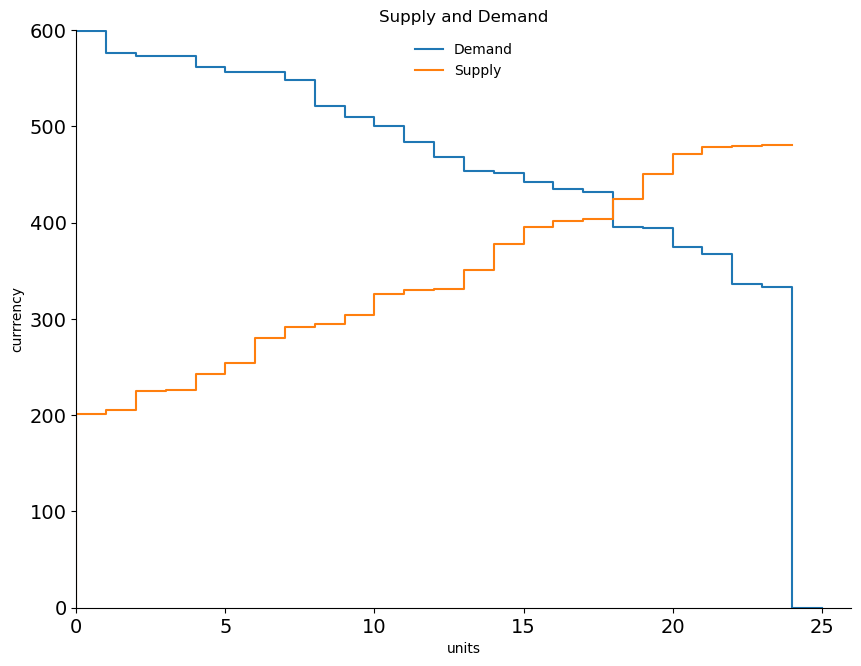

In [3]:
# set up market
agent_maker.make_market("test_market")
agent_maker.plot_market()
market = agent_maker.get_market()

## Show Equilibrium Calculations

In [4]:
agent_maker.show_equilibrium()


When market test_market is in equilibrium we have:
equilibrium price    = 404 - 425
equilibrium quantity = 18
maximum surplus      = 3800



# Institutions

>text file for https://bramp.github.io/js-sequence-diagrams/
```
Environment -> Simulator: Init Agents
Simulator -> Travel: Init Travel
Simulator -> Bargain: Init Bargain
Simulator -> Travel: Start Move
Travel -> Agents: Move
Agents -> Travel: (x, y)
Travel -> Simulator: End, Grid
Simulator -> Bargain: Start Bargain
Bargain -> Agents: Offers
Agents -> Travel: [Bid, ASK, or NULL]
Bargain -> Agents: Transact
Agents -> Travel: [Buy, Sell, or NULL]
Bargain -> Simulator: End, Contracts
```

### Sequence Diagram
![Sequence Diagram](sequence_diagram.svg)

## Messages Table

|Directive  |Sender   |Receiver   |Payload    |Expected Action by Receiver|
| :-------: | :-----: | :-------: | :-------: | :------------: |
|INIT_A     |Env      |Agent(s)   |$e^b$      |Make Agent|
|INIT_T     |Env      |Travel     |grid, agents |Make Grid|
|INIT_B     |Env      |Bargain    |upper, lower, num_rounds |Make Bargain|
|START_S    |Env      |Sim        |num_periods|Start period_walk through periods$^1$, in period_walk send START_M to Travel| 
|START_M    |Sim      |Travel     |period     |Start agent_walk through fixed agent_order$^2$, Send MOVE to Agent in walk|
|MOVE       |Travel   |Agent(s)   |period, g  |Decide (dx, dy), Send MOVE_D|
|MOVE_D     |Agent    |Travel     |(dx, dy)   |Validate, Update g, continue agent_walk, at endsend END_M to sim|
|END_M      |Travel   |Sim        |g          |Start grid_walk thrugh g, when match found send START_B to Bargain|
|START_B    |Sim      |Bargain    |agents at point in g| Randomize agent order, start agent_walk through rounds|  Send OFFER to Agent in walk|
|OFFER      |Bargain  |Agent(s)   |Order Book |Decide Bid or Ask, send BID/ASk/NULL to Bargain| 
|Bid        |Agent    |Bargain    |Bid        |Validate, Update Order_Book, Send OFFER to Next agent, START_T after all offers|
|ASK        |Agent    |Bargain    |Ask        |Validate, Update Order_Book, Send OFFER to Next agent, START_T after all offers|
|NULL       |Agent    |Bargain    |None       |Do Nothing, Send OFFER to Next agent, START_T after all offers|
|START_T    |Bargain  |Bargain    |None       |Validate, Randomize Agent Order, snd TRANSACT to first agent| 
|TRANSACT   |Bargain  |Agent      |Order_Book |Decide BUY or SELL, send BUY/SELL/NULL to Bargain, Send TRANSACT to next Agent| 
|BUY        |Agent    |Bargain    |Order to buy from| Validate, Make Contract, send TRANSACT to Next agent, or continue round walk, or continue g walk, or continue period walk|
|SELL       |Agent    |Bargain    |Order to sell to|  Validate, Make Contract, send TRANSACT to Next agent, or continue round walk, or continue g walk, or continue period walk|
|NULL       |Agent    |Bargain    |None       |send TRANSACT to Next agent, or continue round walk, or continue g walk, or continue period walk|
* We are done when all walks are completed





## Messages

```python
class Message(object):
    """Messages will be passed as objects
    """
    def __init__(self, directive, sender, receiver, payload):
        """
           directive = string to deetermine call
           sender = sender name
           receiver = receiver name
           payload = payload
        """
        self.directive = directive
        self.sender = sender
        self.receiver = receiver
        self.payload = payload
        
    def get_directive(self):
        return self.directive
    
    def get_sender(self):
        return self.sender
    
    def get_receiver(self):
        return self.receiver
    
    def get_payload(self):
        return self.payload
    
    def unpack(self):
        directive = self.directive
        sender = self.sender
        receiver = self.receiver
        payload = self.payload
        return (directive, sender, receiver, payload)
    
    def print_message(self):
        d = self.get_directive()
        print(f"directive = {d}")
        print(f"sender = {self.get_sender()}")
        print(f"receiver = {self.get_receiver()}")
        print(f"payload = {self.get_payload()}")
```

## Message Flow

* **period_loop** `<- START S` (`determines search length`) 
    * **travel_loop** `<- START M`through agents (`updates grid`)
        * MOVE -> MOVE_D
    * **grid_loop** `<- START G`through grid_points (`looking for bargaining opportunities`)
        * if Buyer-Seller Match:  
        * **round_loop** `<- START_B` (`determines bargaining rounds for a given period`) 
            * **offer_loop** `<- START_O` through agents in agent_order (`gets all offers`)
                * OFFER -> BID, ASK, NULL
            * **transact_loop**  `<- START_T` through agents in random_order (`gets all acceptance decisions`)
                * TRANSACT -> BUY, SELL, NULL
                    

```python
sim_period_runner:
    ...
    travel_institution:
        loop through agents:
            request move
            if valid move -> make move
    loop through points in grid:
        if at least one buyer and seller at point:
            bargain_institution:
                loop through rounds:
                    loop through agents:
                        request "BID, ASK" 
                        if valid -> put in order_book
                    loop through agents in random-order:
                        request "BUY, SELL"
                        if valid -> make contract
```

# Trader Strategies

## ZID

> Travel
```Python
    def move_requested(self, pl):
        """
        Make a move in a random direction if you can still trade 
        """
        direction_list = [-1, 0, +1] # 
        if self.cur_unit > self.max_units:
            return_msg = Message("MOVE", self.name, "Travel", (0, 0))
            self.returned_msg(return_msg)
            return return_msg 
        else:
            x_dir = rnd.choice(direction_list)
            y_dir = rnd.choice(direction_list)
            return_msg = Message("MOVE", self.name, "Travel", (x_dir, y_dir))
            self.returned_msg(return_msg)
            return return_msg 
```

> Offer
```Python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            WTP = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            return_msg = Message("BID", self.name, "BARGAIN", WTP)
            self.returned_msg(return_msg)
            return return_msg   

        else: # for SELLER
            WTA = rnd.randint(self.costs[self.cur_unit], self.upper_bound)
            return_msg = Message("ASK", self.name, "BARGAIN", WTA)
            self.returned_msg(return_msg)
            return return_msg  
```

> Transact
```python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            WTP = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            # Find open asks in order book 
            offers = []
            for trader_id in current_offers:
                if current_offers[trader_id] == None:
                    continue
                offer_type = current_offers[trader_id][0]
                offer_amount = current_offers[trader_id][1]
                if offer_type == "ASK":
                    offers.append((trader_id, offer_amount))
            # Make a random choice from offers and try to transact    
            if len(offers) > 0:
                offer = rnd.choice(offers)
                if WTP >= offer[1]:  # offer[1] = sellers willingness to accept
                    seller_id = offer[0]
                    return_msg = Message("BUY", self.name, "BARGAIN", seller_id)
                    self.returned_msg(return_msg)
                    return return_msg    
                else:
                    return_msg = Message("NULL", self.name, "BARGAIN", None)
                    self.returned_msg(return_msg)
                    return return_msg   
            else:
                return_msg = Message("NULL", self.name, "BARGAIN", None)
                self.returned_msg(return_msg)
                return return_msg
 ```           

> Transact
```python
        current_offers = pl  # payload from bargain, self.order_book
        
        if self.type == "BUYER":
            wtp = rnd.randint(self.lower_bound, self.values[self.cur_unit])
            # Find open asks in order book 
            offers = []
            ...
            # Make a random choice from offers and try to transact    
            ...
                seller_id, ask = rnd.choice(offers)
                if wtp >= ask: 
                    return_msg = Message("BUY", self.name, "BARGAIN", seller_id)
                    self.returned_msg(return_msg)
                    return return_msg    
                else:
                    return_msg = Message("NULL", self.name, "BARGAIN", None)
                    self.returned_msg(return_msg)
                    return return_msg   
            ...
```          

## Sample Simulation

In [5]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:<4}-{price:4} -{s_cos:>4}:{s_cur:<3}    {buyer:10} {seller:10}")

sim_name = "Sample One Period Simulation"
num_rounds = 10
num_periods = 1
plot_on = False
debug = False

sim_agents = copy.deepcopy(agents)
contracts = []
sim1 = simp.SimPeriod(sim_name, num_rounds, sim_agents, 
                market, grid_size, debug, plot_on)
for period in range(num_periods):
    sim1.run_period()
    contracts.extend(sim1.get_contracts())

print()
contracts = sim1.get_contracts()
print_contracts(contracts)



CONTRACTS:
rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id
-------------------------------------------------------
 0   0:573 - 221 - 205:0      B_3_ZIDP   S_1_ZIDP  
 0   0:599 - 473 - 226:0      B_1_ZIDP   S_4_ZIDP  
 0   0:562 - 462 - 243:0      B_4_ZIDP   S_3_ZIDP  
 0   0:573 - 387 - 201:0      B_2_ZIDP   S_2_ZIDP  
 1   1:557 - 407 - 331:1      B_4_ZIDP   S_4_ZIDP  
 1   1:576 - 481 - 280:1      B_1_ZIDP   S_3_ZIDP  
 1   1:548 - 424 - 254:1      B_3_ZIDP   S_2_ZIDP  
 2   2:521 - 321 - 225:1      B_4_ZIDP   S_1_ZIDP  
 2   2:500 - 433 - 378:2      B_1_ZIDP   S_4_ZIDP  
 2   2:484 - 356 - 304:2      B_3_ZIDP   S_3_ZIDP  
 2   3:468 - 392 - 292:2      B_1_ZIDP   S_2_ZIDP  
 3   1:557 - 530 - 330:3      B_2_ZIDP   S_3_ZIDP  
 4   4:454 - 296 - 295:3      B_1_ZIDP   S_2_ZIDP  
 4   3:396 - 383 - 326:2      B_3_ZIDP   S_1_ZIDP  
 6   3:510 - 417 - 351:3      B_4_ZIDP   S_1_ZIDP  


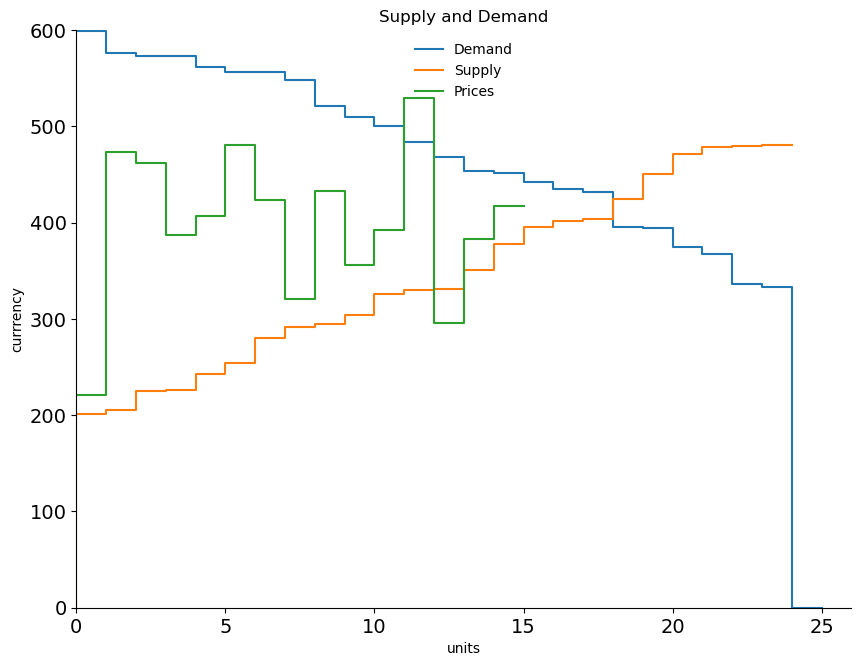

In [6]:
pr_1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
pr_1.plot_prices()

# Performance


In [7]:
pr_1.get_results()
pr_1.display_results()


      equilibrium price range is 404 to 425
      average price = 398.8666666666667
      equilibrium expected contracts = 18, actual contracts = 15
      buyer surplus = 1895, seller surplus = 1742
      actual_surplus = 3637, maximum surplus = 3800
      efficiency = 95.71%.



# Simulation Runner

## Simulation_Sequence Markup

>text file for https://bramp.github.io/js-sequence-diagrams/
```
Simulator -> Session: Control Variables
Note right of Simulator: folder\nnum_traders\nnum_units\ngrid_size\nnum_weeks\nnum_periods\nnum_rounds\nnum_trials
Session -> Week: Session Variables
Note right of Session:Loop through\ntrials
Note right of Session:sub_folder\ncontrol vars\ntrial_num\ntreatment vars:\n..starting grid\n..preferences
Week -> Period: Period Variables
Note right of Week: week_num\nold grid\nValues/Costs
Period -> Agents: Init Incentives
Note right of Period: Loop through\nperiods in week
Note right of Period: period_num\ncur_unit = 0\ntravel_info\nprice_info
Period -> Travel: old grid
Travel -> Agents: Make Move
Note right of Travel: Loop through \nagents
Agents -> Travel: Move
Note right of Agents:(dx, dy)
Travel -> Period: data from travel
Note right of Travel: data:\nnew_grid\nmove history
Period -> Matching: Find_Trades
Note right of Period: Initiates search\nof new grid for\nbuyer/seller matches
Matching -> Bargain: Agent List
Note right of Matching: agents at gird location\nnum_rounds
Note right of Bargain: loop thorugh rounds
Bargain -> Agents: Make Offer
Note right of Bargain:Loop through\nagents
Agents -> Bargain: Offer
Bargain -> Agents: Make Trade
Note right of Bargain:Loop through\nagents
Agents -> Bargain: Trade
Bargain -> Period: data from bargain
Note right of Bargain:offer/trade history\ncontract:\nprice\nbuyer_id\nseller_id\nbuyer_unit\nbuyer_value\nseller_unit\nseller_cost
Period -> Week: data from period
Note right of Period: Data:\ntravel history\nbargain history\ncontracts
Week -> Session: data from week
Session -> Simulator: data from session
```

## Simulation Sequence Diagram

![Simulation Diagram](simulation_diagram.svg)

## Pseudo Code for Simulation Runs 
```
Simulator:
    Get Simulator Variables: sim_name
        Make main folder: sim_name + date
    Get Control Variables
        Write variables to main folder
    Get treat_key = treatment_name, treatment_list 
    Loop through treatments (using treatment as index) 
        Loop num_trials times (using trial as index)
            Make agents (set preferences and locations)
            Loop num_weeks times (using week as index)
                Init agents (preferences and locations)
                Loop num_period times (using period as index)
                    Loop through agents (using agent as index)
                        agent makes travel decisions (upgrades grid location)
                    Loop through grid (using loc as index)
                        If there is a Buyer and Seller at loc:
                            Loop num_round times (using round as location)
                            Loop through agents@loc (using agent as index)
                                agent makes offer (Bid or Ask) in order_book
                            Loop through agents@loc in random order (using agent as index)
                                agent makes Buy or Sell decision to offer in order_book
                    Record period_data
                Record week_data
            Record session_data
        Record trial_data
       

## Folder Structure
```
dm_simulations/
    'sim_name + date'/
       'sim_name'.config
       'treatments'/
           'treatments'.config
           'treatment_id'/
               'treatment_id'.config
               'trials'/
                   'trial###'/
                       datum['id'][week][period][round]       
```

# Simulations

## Runner with treatment lists

In [8]:
def print_contracts(contracts):
    print("CONTRACTS:")
    print("rnd, b_cu:b_val -price- s_cos:s_cu  buyer_id, seller_id")
    print("-------------------------------------------------------")
    for contract in contracts:
        round = contract[0]
        price = contract[1]
        buyer = contract[2]
        seller = contract[3]
        b_cur = contract[4]
        b_val = contract[5]
        s_cur = contract[6]
        s_cos = contract[7]
        print(f"{round:2} {b_cur:3}:{b_val:4} -{price:4}-{s_cos:4}{s_cur:3}    {buyer:10} {seller:10}")

def print_locations(agents):
    for agent in agents:
        print(f"agent {agent.name} is at location {str(agent.get_location())}")

def chk(x, index):
    typ = type(x)
    assert typ == int or typ == list, "bad type"
    if type(x) == int:
        return x
    elif type(x) == list:
        return x[index]
        
def make_simulation(controls, treat_key):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 
    treat_number = 0
    num_weeks = chk(controls['num_weeks'], treat_number)
    num_periods = chk(controls['num_periods'], treat_number)
    num_rounds = chk(controls['num_rounds'], treat_number)
    grid_sizes = chk(controls['grid_size'], treat_number)
    num_traders = chk(controls['num_traders'], treat_number)
    num_units = chk(controls['num_units'], treat_number)
    lower_bound = chk(controls['lower_bound'], treat_number)
    upper_bound = chk(controls['upper_bound'], treat_number)
    num_trials = chk(controls['num_trials'], treat_number)

    # Setup data tsructure for effs
    effs = []
    for k, treat in enumerate(controls[treat_key]):
        subeffs = []
        for trial in range(num_trials):
            subeffs.append(0)
        effs.append(subeffs)


    print('Started Simulation')
    for trial in range(num_trials):
        for index, treat in enumerate(controls[treat_key]):
            
            # collect controls
            num_periods = chk(controls['num_periods'], index)
            num_rounds = chk(controls['num_rounds'], index)
            grid_size = chk(controls['grid_size'], index)
            num_traders = chk(controls['num_traders'], index)
            num_units = chk(controls['num_units'], index)
            lower_bound = chk(controls['lower_bound'], index)
            upper_bound = chk(controls['upper_bound'], index)
            
            # make agents
            agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                        grid_size, lower_bound, upper_bound, debug)
            agent_maker.make_agents()
            agent_maker.set_locations(grid_size)
            agents = agent_maker.get_agents()

            # set up market
            agent_maker.make_market("test_market")
            market = agent_maker.get_market()
          
            # run sim
            contracts = []

            sim_agents = copy.deepcopy(agents)  # reinitialize
            sim1 = simp.SimPeriod(sim_name, num_rounds, sim_agents, 
                   market, grid_size, debug, plot_on)
            for period in range(num_periods):
                sim1.run_period()
                contracts.extend(sim1.get_contracts())
            # process results
            pr1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
            pr1.get_results()
            effs[index][trial] = pr1.get_efficiency()
    print('Finished Simulation')
    return effs



## Increase bargaining rounds

### Initialize and run

In [10]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 1,
    'num_rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grid_size': 1,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'num_rounds'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_1 = make_simulation(controls, key)


Started Simulation
Finished Simulation


### Graph Efficiences

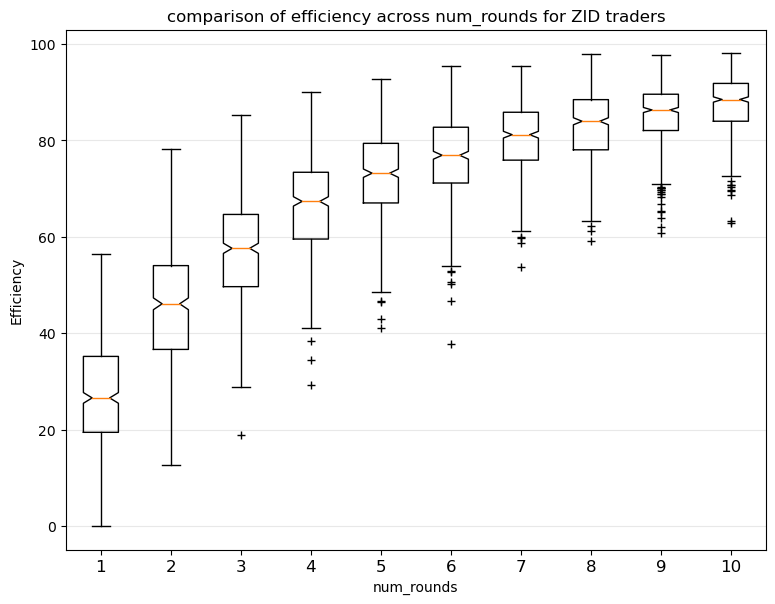

In [11]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_1, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

As we increase the number of bargaining rounds in a 1x1 grid the ZID agents have opportunities to make more rounds of offers. This increases the opportunity for trades and thus increases the gains from exchange.  

## Increase grid_size

### initialize and run

In [12]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 1,
    'num_rounds': 10,
    'grid_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'grid_size'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_2 = make_simulation(controls, key)


Started Simulation
Finished Simulation


### Graph efficiencies

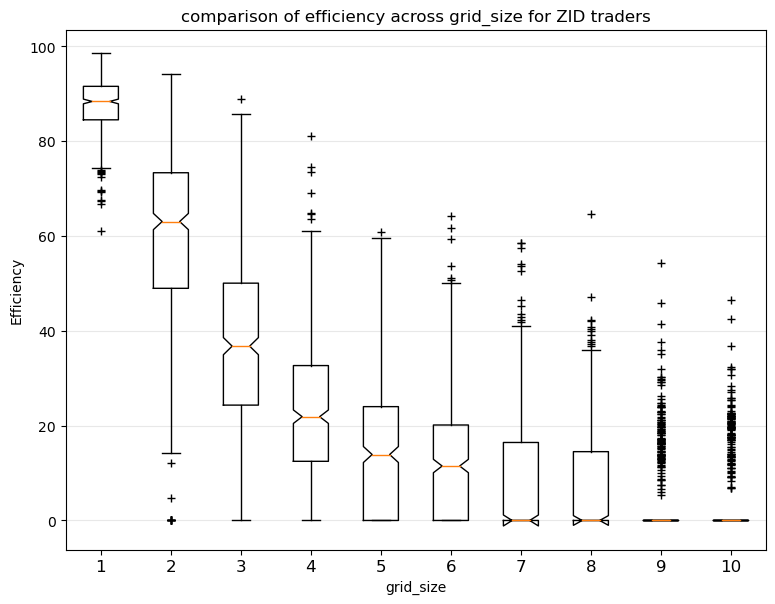

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_2, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

## Increase Search Periods for Agents 

### Initialize and run

In [14]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_rounds': 10,
    'grid_size': 5,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 500
}

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_3 = make_simulation(controls, key)


Started Simulation
Finished Simulation


### Graph Efficiencies

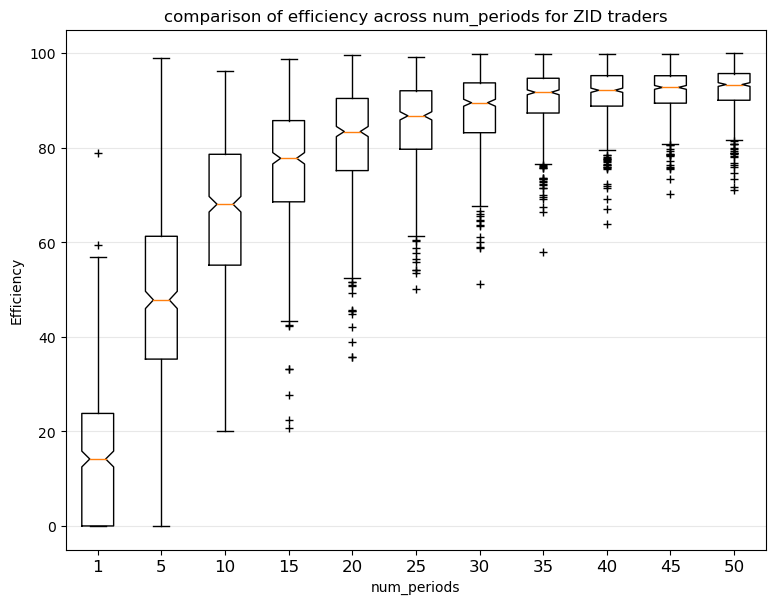

In [15]:
fig, ax1 = plt.subplots(figsize=(8, 8))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_3, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Narrative

##  Round Effect (using Two tables)

### Initialize and Run

In [16]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 5), (ZID, 5)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'num_rounds': 1,
    'grid_size': 5,
    'num_traders': 10,
    'num_units': 6,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 50
}

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_4 = make_simulation(controls, key)
for k in data_table_4:
    print(k)

Started Simulation
Finished Simulation
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.635135135135133, 0.0, 18.563432835820894, 17.96554552912223, 6.812447434819176, 0.0, 7.836644591611479, 0.0, 0.0, 0.0, 18.30296437313027, 22.41766467065868, 15.02308015107008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.00138696255201, 6.2551215514886644, 0.0, 17.390153520381155, 0.0, 0.0, 10.28504260946224, 0.0, 0.0, 0.0, 0.0, 7.216494845360824, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.363436123348018, 0.0, 0.0, 8.311620635747785, 8.269484808454425, 0.0]
[20.818982013011862, 5.9943977591036415, 22.367101303911735, 22.398363589874712, 0.0, 32.90971670638073, 8.554817275747508, 29.70747562296858, 18.420368926994023, 15.545395166557805, 20.309611829944547, 30.669281686687917, 8.040745557000434, 17.1764130168828, 27.358916478555308, 46.225923997917754, 26.72413793103448, 19.76140080815855, 33.646055437100216, 19.48249619482496, 0.0, 9.101303453007088, 16.708479678876067, 5.9150544807649545, 5.5762081784386615, 28.40011699327289, 8

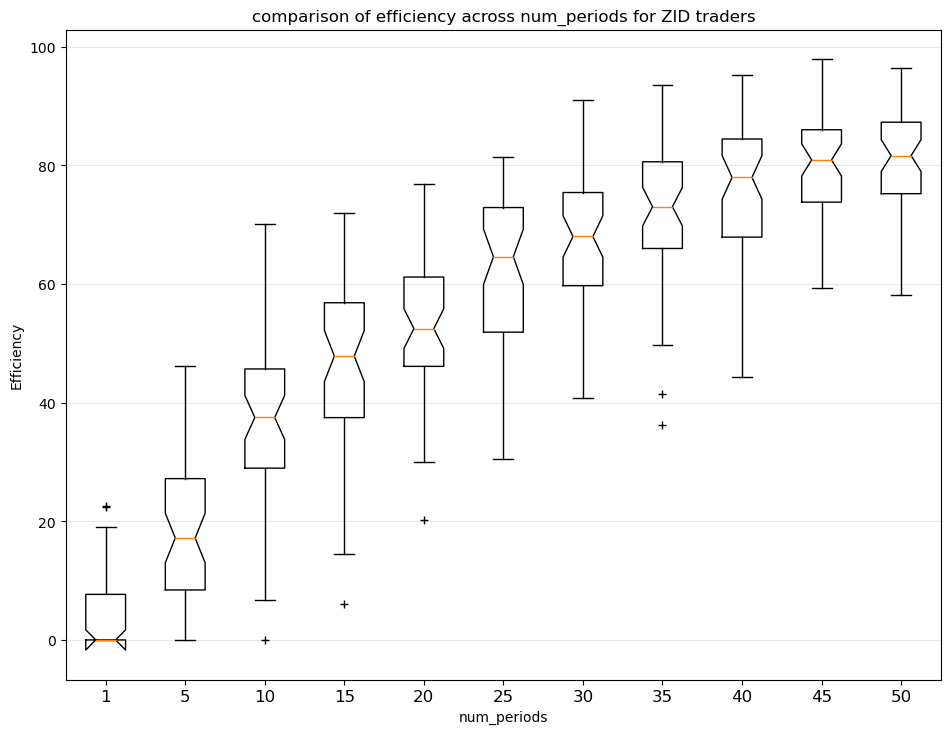

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_4, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

### Graph Efficiencies

In [18]:
whole_table = []
# Rearrange data in tables
for k in range(len(data_table_3)):
    whole_table.append(data_table_3[k])
    whole_table.append(data_table_4[k])
treatments = []
for k in controls['num_periods']:
    treatments.append(k)
    treatments.append(k)
print(treatments)
    


[1, 1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 35, 35, 40, 40, 45, 45, 50, 50]


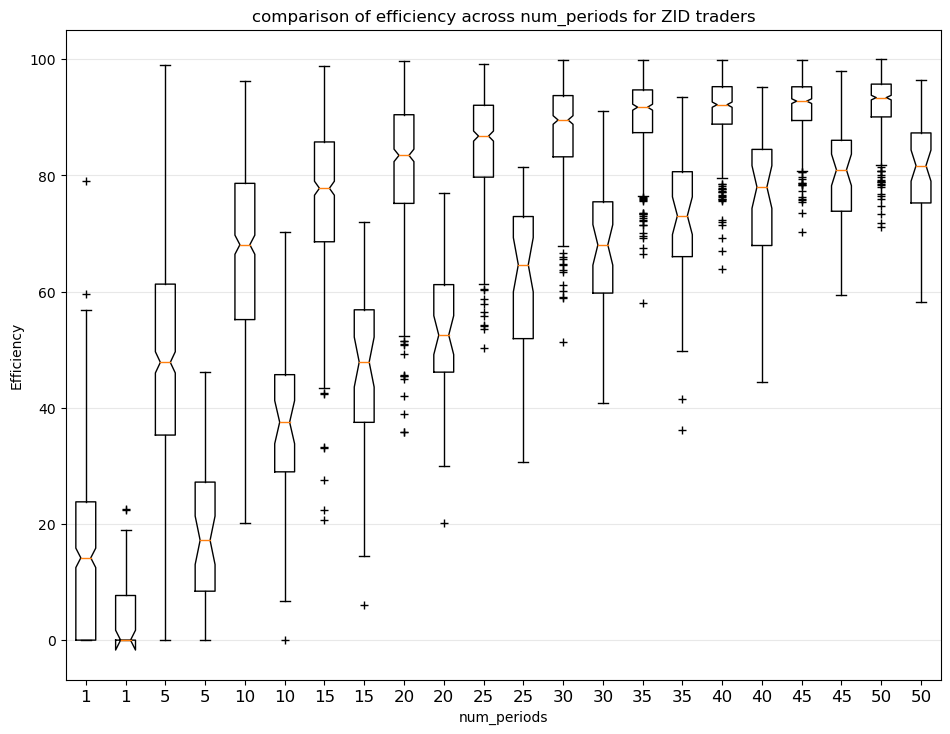

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(whole_table, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(treatments, fontsize=12)

plt.show()

### Narrative

## Round effect for Grid Size 10 and 50 periods

### Init and run

In [21]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZID, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

controls = {
    'num_weeks': 1,
    'num_periods': 30,
    'num_rounds': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'grid_size': 5,
    'num_traders': 20,
    'num_units': 10,
    'lower_bound': 200,
    'upper_bound': 600,
    'num_trials': 50
}

key = 'num_rounds'
graph_title = 'comparison of efficiency across ' + key + " for ZID traders"
data_table_5 = make_simulation(controls, key)


Started Simulation
Finished Simulation


### Graph Efficiencies

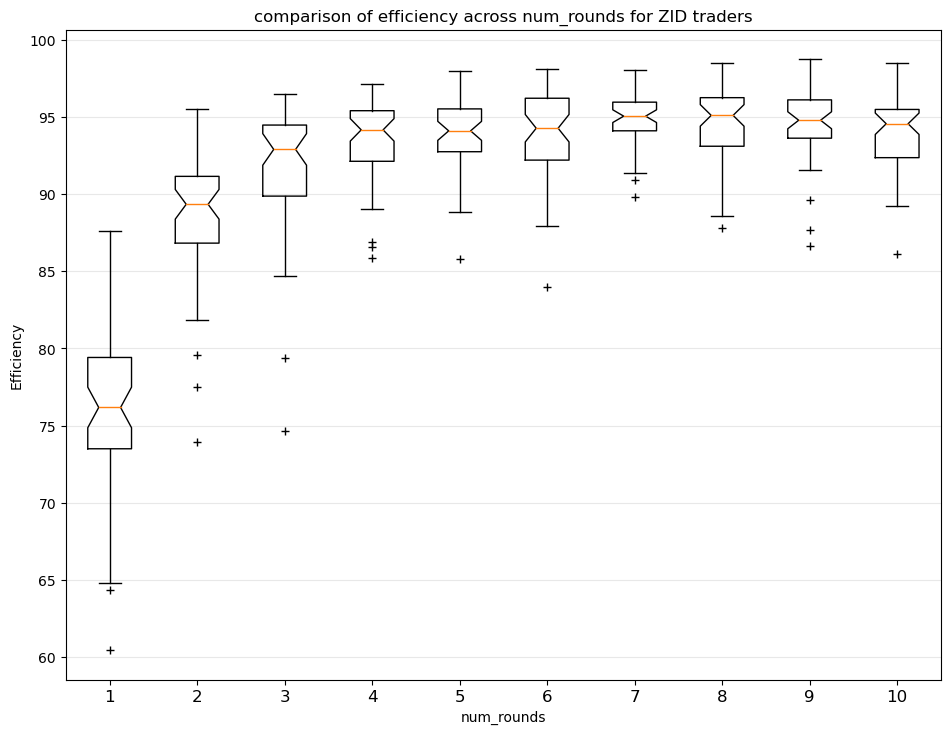

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig.canvas.manager.set_window_title('A Boxplot Example')
fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = ax1.boxplot(data_table_5, notch=True, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title=graph_title,
    xlabel=key,
    ylabel='Efficiency',
)

ax1.set_xticklabels(controls[key], fontsize=12)

plt.show()

# Runner for comparing efficiencies between strategies 

```python
generate agent preferences
sim_weekly_runner:
    reset agent preferences
    loop through periods
        sim_period_runner:
        ...
            travel_institution:
                loop through agents:
                    request move
                    if valid move -> make move
            loop through points in grid:
            if at least one buyer and seller at point:
                bargain_institution:
                    loop through rounds:
                        loop through agents:
                            request "BID, ASK" 
                            if valid -> put in order_book
                        loop through agents in random-order:
                            request "BUY, SELL"
                            if valid -> make contract
```

In [23]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation_1():
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    num_periods = 7
    num_weeks = 100
    num_rounds = 5
    grid_size = 15
    num_traders = 20
    num_units = 8
    lower_bound = 200 
    upper_bound = 600

    effs = []
    locs = []
  

    # make agents
    agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simp.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
    
    return effs, locs



In [24]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation_1():
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 
    num_trials = 100
    num_periods = 7
    num_weeks = 50
    num_rounds = 5
    grid_size = 15
    num_traders = 20
    num_units = 8
    lower_bound = 200 
    upper_bound = 600

    effs = []
    locs = []
  

    # make agents
    agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simp.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
    
    return effs, locs



## Test ZID

In [25]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZID, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_6, locs = make_simulation_1()

for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)

18 {(1, 11): 1, (11, 6): 2, (8, 11): 1, (14, 12): 2, (6, 10): 1, (14, 7): 1, (4, 6): 1, (11, 5): 1, (3, 8): 1, (12, 4): 1, (14, 9): 1, (1, 13): 1, (9, 1): 1, (0, 10): 1, (9, 14): 1, (9, 5): 1, (5, 3): 1, (13, 1): 1}
20 {(4, 14): 1, (11, 7): 1, (8, 10): 1, (13, 13): 1, (3, 10): 1, (14, 4): 1, (5, 8): 1, (10, 8): 1, (3, 9): 1, (10, 6): 1, (14, 13): 1, (14, 7): 1, (1, 14): 1, (10, 7): 1, (10, 1): 1, (4, 9): 1, (10, 13): 1, (7, 5): 1, (5, 4): 1, (14, 2): 1}
19 {(4, 13): 1, (12, 5): 1, (6, 13): 1, (12, 14): 1, (5, 8): 1, (14, 2): 1, (6, 4): 1, (8, 9): 1, (3, 10): 2, (10, 5): 1, (13, 12): 1, (11, 6): 1, (1, 11): 1, (9, 9): 1, (12, 2): 1, (14, 11): 1, (8, 5): 1, (7, 5): 1, (13, 5): 1}
19 {(5, 10): 1, (13, 7): 1, (2, 14): 1, (9, 14): 1, (8, 10): 1, (13, 3): 2, (10, 6): 1, (5, 7): 1, (5, 9): 1, (7, 6): 1, (14, 11): 1, (6, 11): 1, (3, 8): 1, (10, 5): 1, (1, 9): 1, (13, 11): 1, (10, 9): 1, (11, 4): 1, (13, 6): 1}
20 {(7, 8): 1, (13, 11): 1, (0, 12): 1, (10, 10): 1, (5, 10): 1, (14, 5): 1, (12, 8)

## Test ZIDA

In [26]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZIDA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_7, locs = make_simulation_1()
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)

20 {(1, 5): 1, (11, 13): 1, (11, 2): 1, (8, 6): 1, (1, 6): 1, (11, 0): 1, (3, 10): 1, (2, 10): 1, (0, 14): 1, (1, 7): 1, (5, 0): 1, (3, 4): 1, (4, 6): 1, (3, 5): 1, (12, 4): 1, (8, 10): 1, (12, 8): 1, (13, 10): 1, (10, 2): 1, (10, 9): 1}
16 {(0, 9): 1, (14, 13): 1, (10, 3): 2, (11, 4): 2, (2, 5): 2, (11, 2): 1, (2, 6): 1, (0, 11): 1, (0, 14): 1, (1, 7): 1, (2, 1): 1, (4, 2): 1, (4, 4): 1, (14, 3): 1, (9, 10): 2, (13, 9): 1}
17 {(1, 8): 1, (12, 12): 1, (10, 3): 2, (11, 4): 2, (2, 5): 2, (13, 1): 1, (2, 10): 1, (2, 13): 1, (1, 14): 1, (1, 7): 1, (2, 3): 1, (5, 0): 1, (5, 3): 1, (14, 5): 1, (7, 13): 1, (12, 10): 1, (10, 10): 1}
14 {(0, 4): 2, (12, 14): 2, (10, 3): 2, (11, 4): 3, (2, 5): 2, (11, 1): 1, (0, 12): 1, (3, 12): 1, (5, 11): 1, (4, 0): 1, (6, 2): 1, (6, 3): 1, (8, 10): 1, (13, 12): 1}
15 {(0, 5): 1, (12, 14): 2, (10, 3): 2, (11, 4): 3, (2, 5): 2, (10, 0): 1, (0, 13): 1, (4, 9): 1, (7, 12): 1, (0, 3): 1, (4, 1): 1, (6, 0): 1, (5, 2): 1, (12, 7): 1, (11, 8): 1}
14 {(0, 6): 1, (12, 

## Compare ZID and ZIDA efficiencies grid_size = 10

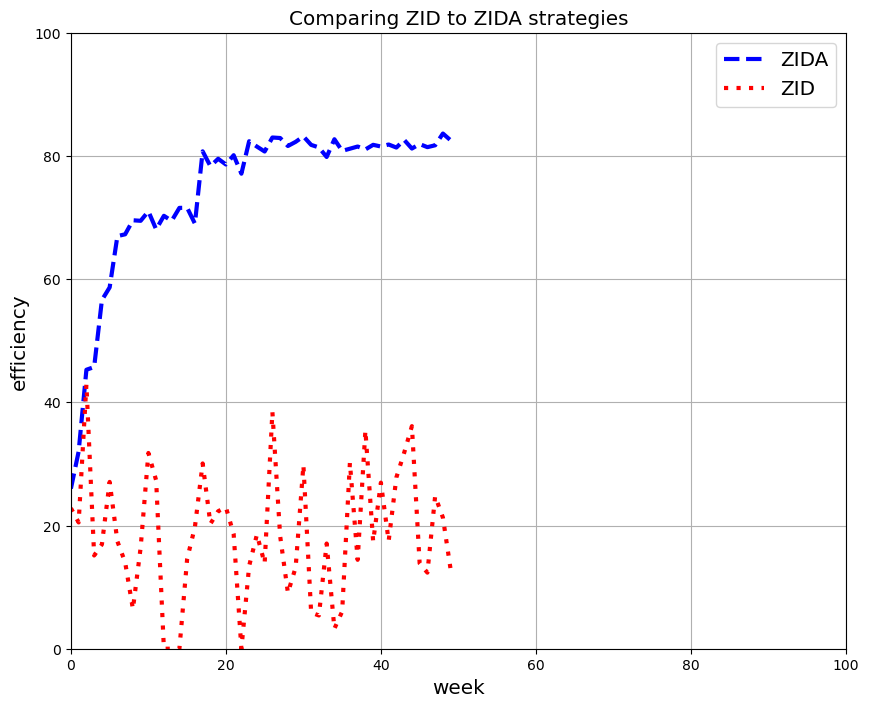

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))  
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dashed', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 100)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDPA

In [28]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 

trader_objects = [(ZIDPA, 10), (ZIDPA, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_8, locs = make_simulation_1()
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)

19 {(13, 0): 1, (12, 14): 1, (8, 7): 1, (10, 4): 1, (10, 1): 2, (13, 8): 1, (12, 9): 1, (9, 3): 1, (11, 3): 1, (12, 6): 1, (3, 5): 1, (6, 2): 1, (12, 7): 1, (6, 12): 1, (2, 3): 1, (13, 6): 1, (6, 3): 1, (11, 1): 1, (3, 4): 1}
19 {(14, 0): 1, (12, 11): 1, (8, 10): 1, (13, 4): 1, (10, 2): 2, (13, 8): 1, (13, 11): 1, (10, 6): 1, (12, 1): 1, (12, 7): 1, (3, 5): 1, (5, 3): 1, (12, 8): 1, (5, 11): 1, (4, 0): 1, (14, 3): 1, (7, 4): 1, (12, 2): 1, (6, 5): 1}
18 {(11, 1): 1, (8, 6): 1, (7, 13): 1, (14, 2): 1, (10, 2): 2, (14, 9): 1, (13, 12): 1, (9, 10): 1, (10, 0): 2, (10, 6): 1, (4, 5): 1, (1, 3): 1, (12, 6): 1, (5, 9): 1, (5, 0): 1, (11, 0): 1, (11, 6): 1, (8, 5): 1}
17 {(12, 5): 1, (9, 4): 1, (5, 14): 1, (12, 2): 1, (10, 2): 2, (14, 8): 1, (11, 11): 1, (9, 10): 1, (10, 0): 3, (10, 9): 1, (5, 3): 1, (1, 3): 1, (13, 9): 1, (5, 5): 1, (6, 1): 1, (11, 4): 1, (9, 8): 1}
14 {(14, 2): 1, (7, 4): 2, (4, 11): 1, (12, 6): 1, (10, 2): 2, (14, 9): 2, (13, 11): 1, (9, 8): 1, (10, 0): 3, (12, 7): 1, (3, 

## Compare ZID, ZIDA, and ZIDPA efficiencies grid_size = 10

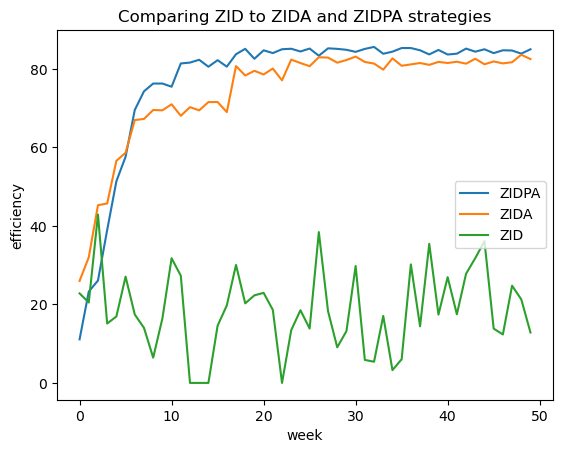

In [29]:
fig, ax = plt.subplots()
ax.plot(data_table_8, label = 'ZIDPA')
ax.plot(data_table_7, label = 'ZIDA')
ax.plot(data_table_6, label = 'ZID')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing ZID to ZIDA and ZIDPA strategies')
ax.legend()

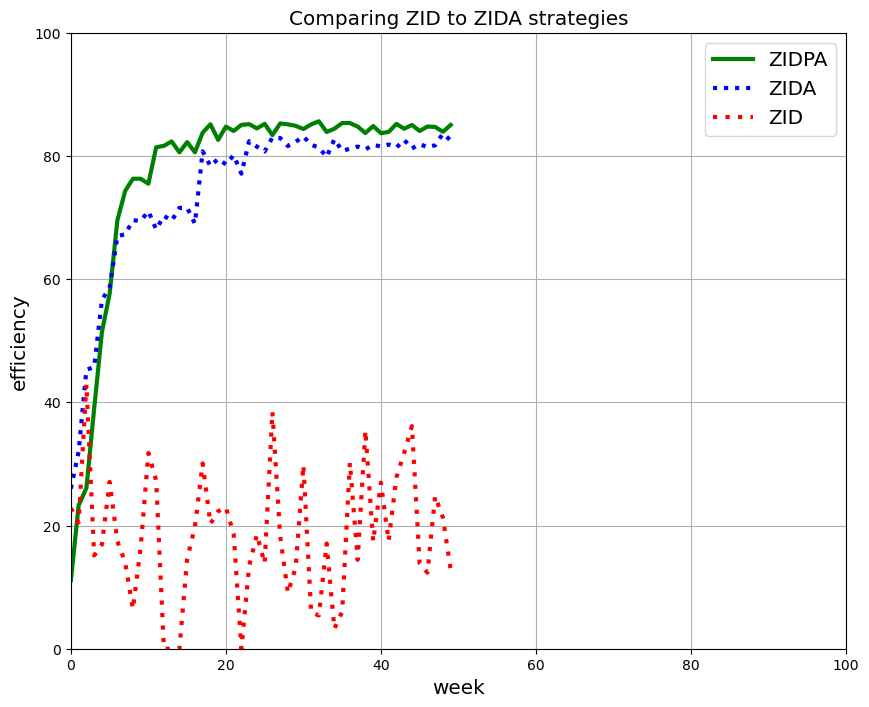

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_8, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_7, label = 'ZIDA', linestyle = 'dotted', color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 100)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

## Test ZIDPR

In [31]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 

trader_objects = [(ZIDPR,10), (ZIDPR,10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

key = 'num_periods'
graph_title = 'comparison of efficiency across ' + key + " for ZIDA traders"
data_table_9, locs = make_simulation_1()
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)

19 {(7, 2): 1, (12, 5): 1, (3, 7): 1, (5, 8): 1, (9, 14): 1, (4, 6): 1, (8, 11): 1, (5, 10): 1, (0, 10): 1, (4, 8): 1, (6, 11): 1, (11, 10): 1, (7, 8): 1, (0, 14): 2, (9, 12): 1, (9, 10): 1, (1, 12): 1, (1, 8): 1, (3, 14): 1}
19 {(9, 1): 1, (14, 3): 1, (7, 6): 1, (6, 10): 1, (8, 13): 1, (5, 2): 1, (6, 11): 2, (4, 14): 1, (1, 12): 1, (5, 11): 1, (11, 6): 1, (9, 6): 1, (0, 14): 1, (10, 11): 1, (12, 10): 1, (2, 12): 1, (4, 12): 1, (3, 14): 1, (0, 12): 1}
16 {(8, 1): 1, (14, 4): 1, (6, 7): 2, (5, 11): 1, (8, 12): 1, (7, 10): 1, (3, 14): 2, (2, 12): 2, (5, 12): 2, (12, 5): 1, (10, 5): 1, (3, 13): 1, (11, 12): 1, (12, 12): 1, (0, 12): 1, (2, 10): 1}
18 {(11, 2): 1, (12, 3): 1, (8, 8): 1, (5, 13): 1, (7, 12): 1, (6, 4): 1, (7, 10): 1, (3, 14): 2, (2, 12): 2, (6, 11): 1, (4, 11): 1, (11, 5): 1, (13, 7): 1, (0, 14): 1, (14, 13): 1, (10, 12): 1, (0, 12): 1, (2, 10): 1}
16 {(14, 1): 1, (12, 4): 2, (10, 9): 1, (4, 14): 1, (6, 9): 1, (9, 4): 1, (7, 10): 2, (3, 14): 2, (2, 12): 2, (6, 11): 1, (4, 11

## Compare ZID, ZIDA,  ZIDPA and ZIDPR efficiencies grid_size = 10

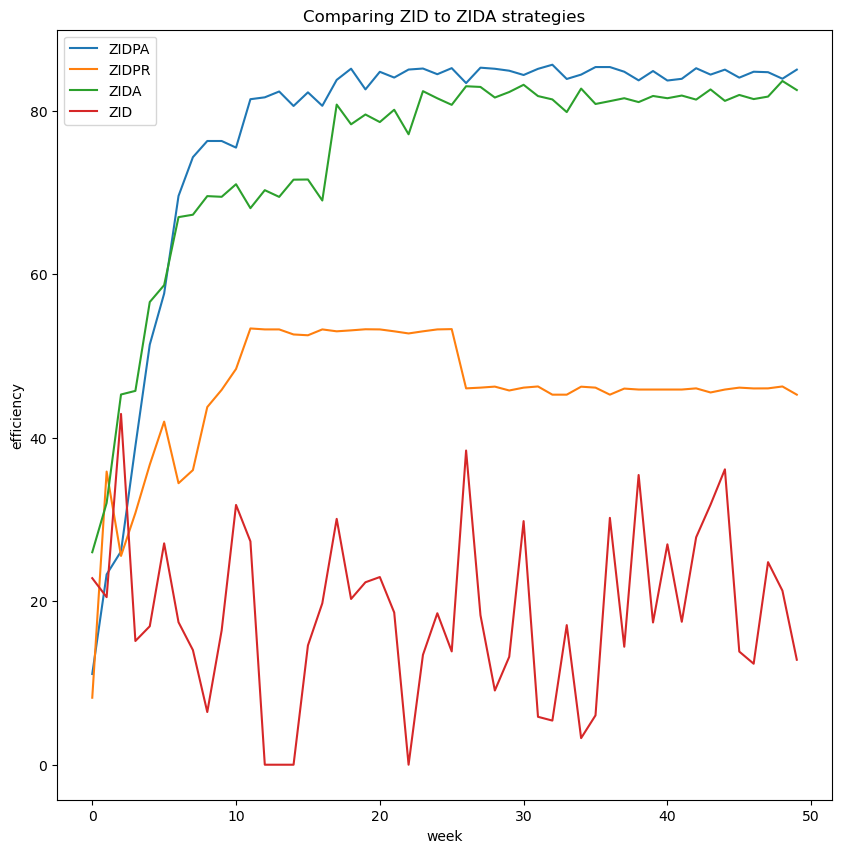

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(data_table_8, label = 'ZIDPA')
ax.plot(data_table_9, label = 'ZIDPR')
ax.plot(data_table_7, label = 'ZIDA')
ax.plot(data_table_6, label = 'ZID')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing ZID to ZIDA strategies')
ax.legend()

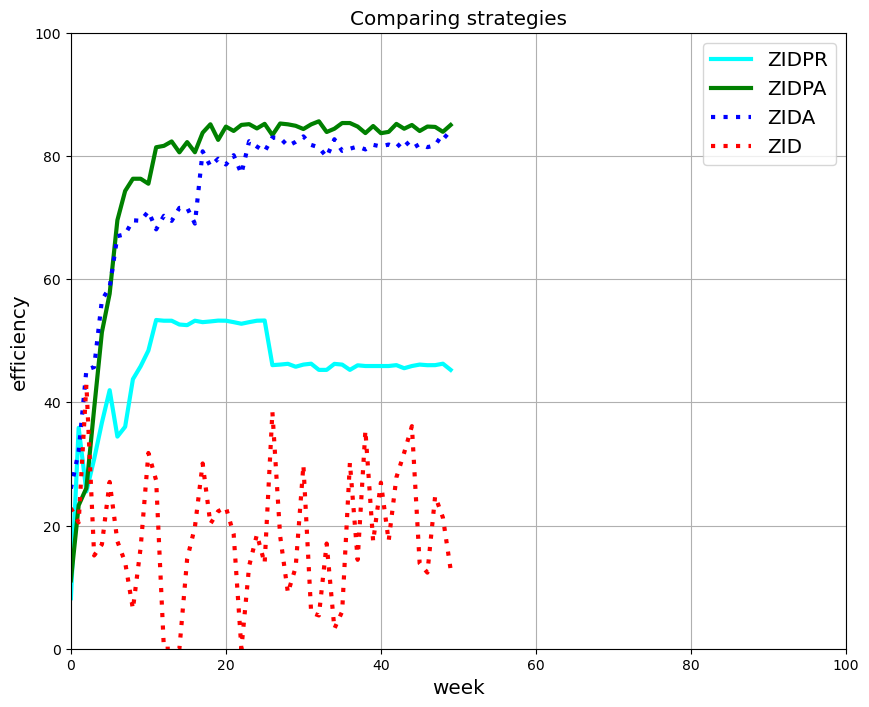

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_9, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.plot(data_table_8, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_7, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)
ax.plot(data_table_6, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, 100)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing strategies', size = 'x-large')
ax.legend(fontsize='x-large')

# Compare agent strategies/types competing within periods

## Runner for running weeks

In [34]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation_2():
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    num_periods = 7
    num_weeks = 100
    num_rounds = 5
    grid_size = 1
    num_traders = 20
    num_units = 8
    lower_bound = 200 
    upper_bound = 600

    effs = []
    type_effs = []
    locs = []
  

    # make agents
    agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simp.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
        type_eff = pr1.get_type_surplus()
        type_effs.append(type_eff)  
    return effs, type_effs, locs



### Initialize and run ZID vs ZIDP

In [35]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZIDP, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDP traders"
data_table_10, data_table_11, locs = make_simulation_2()

ZID_surplus = []
ZIDP_surplus = []
for type_surplus in data_table_11:
    if 'ZID' in type_surplus:
        ZID_surplus.append(type_surplus['ZID'])
    else:
        ZID_surplus.append(0)
    if 'ZIDP' in type_surplus:
        ZIDP_surplus.append(type_surplus['ZIDP'])
    else:
        ZIDP_surplus.append(0)   

data_table_12 = [ZID_surplus, ZIDP_surplus]

"""
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)
"""

'\nfor loc in locs:\n    loc_d = {}\n    for g_loc in loc:\n        if g_loc in loc_d.keys():\n            loc_d[g_loc] += 1\n        else:\n            loc_d[g_loc] = 1\n    print(len(loc_d), loc_d)\n'

### Graph Efficiencies

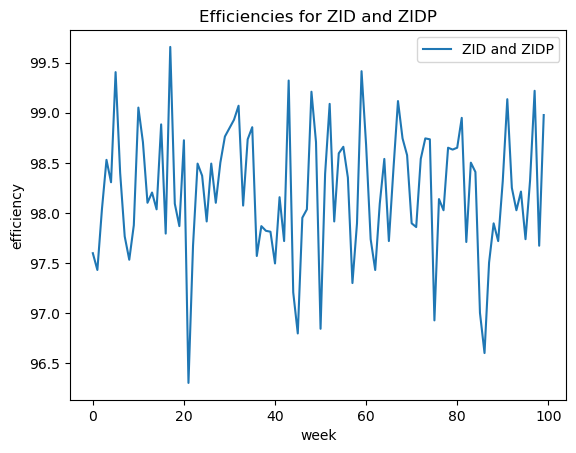

In [36]:
fig, ax = plt.subplots()  
ax.plot(data_table_10, label = 'ZID and ZIDP')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Efficiencies for ZID and ZIDP')
ax.legend()

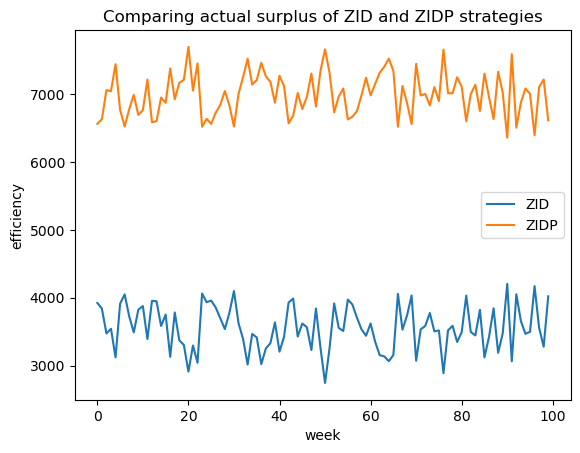

In [37]:
fig, ax = plt.subplots()  
ax.plot(ZID_surplus, label = 'ZID')
ax.plot(ZIDP_surplus, label = 'ZIDP')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZID and ZIDP strategies')
ax.legend()

## Runner for running weeks

In [38]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_simulation(num_periods, num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    effs = []
    type_effs = []
    locs = []
  

    # make agents
    agent_maker = mkt.MakeAgents(num_traders, trader_objects, num_units, 
                                grid_size, lower_bound, upper_bound, debug)
    agent_maker.make_agents()
    agent_maker.set_locations(grid_size)
    agents = agent_maker.get_agents()

    # set up market
    agent_maker.make_market("test_market")
    market = agent_maker.get_market()

    # run sim
    locs.append(make_locs(agents))
    for week in range(num_weeks):
        for agent in agents:
            agent.start(None)
        contracts = []
        sim1 = simp.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size, debug, plot_on)
        for period in range(num_periods):
            sim1.run_period()
            contracts.extend(sim1.get_contracts())
        
        locs.append(make_locs(agents))
        # process results
        pr1 = pr.ProcessResults(market, sim_name, agents, contracts, debug)
        pr1.get_results()
        eff = pr1.get_efficiency()
        effs.append(eff)
        type_eff = pr1.get_type_surplus()
        type_effs.append(type_eff)  
    return effs, type_effs, locs



## Runner for monte carlo simulations

In [39]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_monte_carlo(num_trials, num_periods, num_weeks,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    effs = []
    type_effs = []
    locs = []
  
    for trial in range(num_trials):
        make_simulation(num_periods, num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                    trader_objects)

    return effs, type_effs, locs



In [40]:
num_trials = 100
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
trader_objects =[(ZID, 10), (ZIDA, 10)]

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600
make_monte_carlo(num_trials, num_periods, num_weeks,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects)

([], [], [])

## Compare ZID vs ZIDA

In [41]:
ZID = dm_agents.ZID     # name of agent class
ZIDA = dm_agents.ZIDA   # name of agent class
ZIDP = dm_agents.ZIDP   # name of class that accepts best offer

trader_objects = [(ZID, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDA traders"
data_table_13, data_table_14, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZID_surplus = []
ZIDA_surplus = []

for type_surplus in data_table_14:
    if 'ZID' in type_surplus:
        ZID_surplus.append(type_surplus['ZID'])
    else:
        ZID_surplus.append(0)
    if 'ZIDA' in type_surplus:
        ZIDA_surplus.append(type_surplus['ZIDA'])
    else:
        ZIDA_surplus.append(0)   

data_table_15 = [ZID_surplus, ZIDA_surplus]

"""
for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)
"""

'\nfor loc in locs:\n    loc_d = {}\n    for g_loc in loc:\n        if g_loc in loc_d.keys():\n            loc_d[g_loc] += 1\n        else:\n            loc_d[g_loc] = 1\n    print(len(loc_d), loc_d)\n'

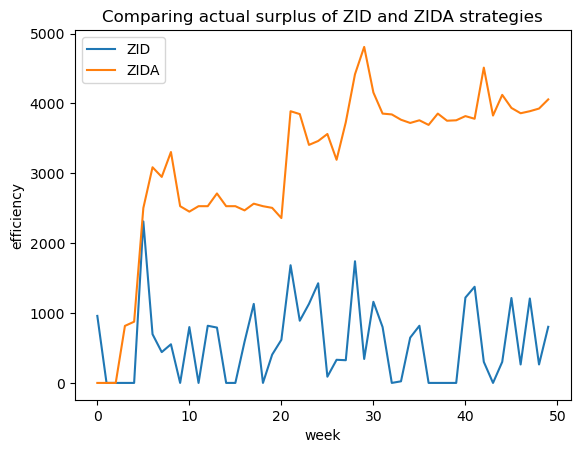

In [42]:
fig, ax = plt.subplots()  
ax.plot(ZID_surplus, label = 'ZID')
ax.plot(ZIDA_surplus, label = 'ZIDA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZID and ZIDA strategies')
ax.legend()

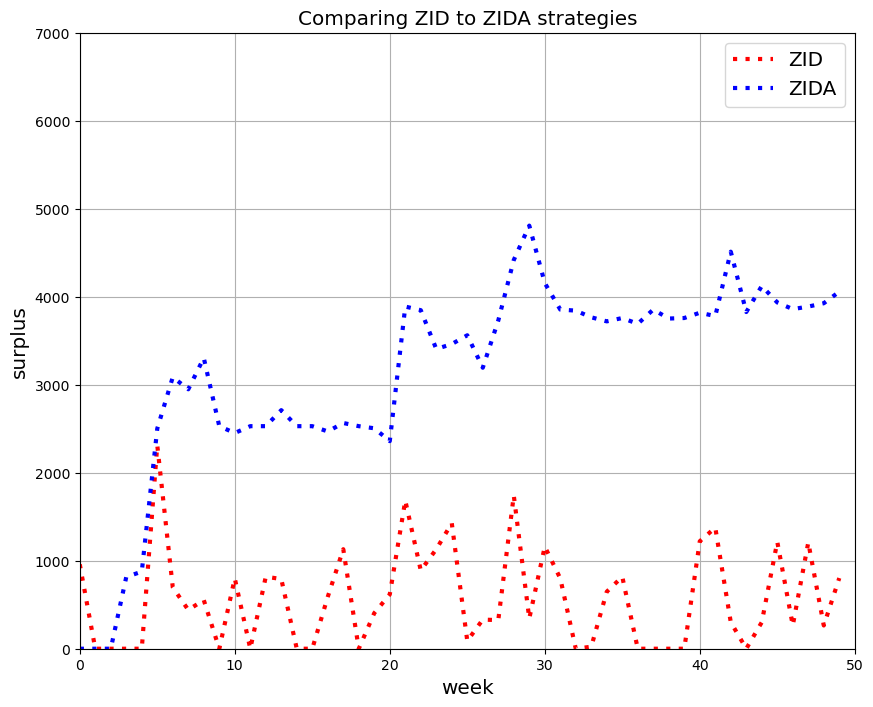

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZID_surplus, label = 'ZID', linestyle = (0, (1, 2)), color='red', lw =3)
ax.plot(ZIDA_surplus, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

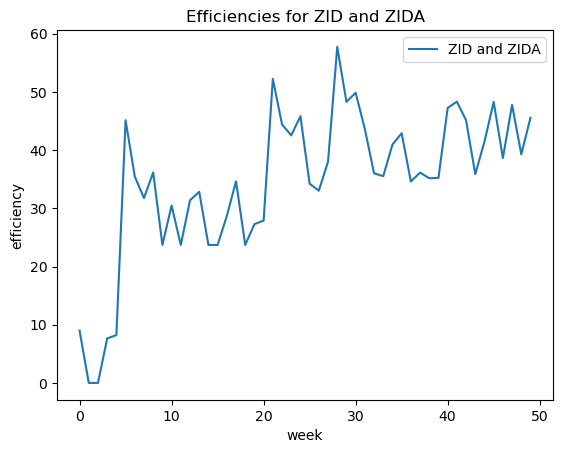

In [44]:
fig, ax = plt.subplots()  
ax.plot(data_table_13, label = 'ZID and ZIDA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Efficiencies for ZID and ZIDA')
ax.legend()

## Compare ZIDPA vs ZIDA

In [45]:
ZID = dm_agents.ZID       # name of agent class
ZIDA = dm_agents.ZIDA     # name of agent class
ZIDP = dm_agents.ZIDP     # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 

trader_objects = [(ZIDPA, 10), (ZIDA, 10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 50
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDP traders"
data_table_16, data_table_17, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZIDPA_surplus = []
ZIDA_surplus = []
for type_surplus in data_table_17:
    ZIDPA_surplus.append(type_surplus['ZIDPA'])
    ZIDA_surplus.append(type_surplus['ZIDA'])

data_table_18 = [ZIDPA_surplus, ZIDA_surplus]


for loc in locs:
    loc_d = {}
    for g_loc in loc:
        if g_loc in loc_d.keys():
            loc_d[g_loc] += 1
        else:
            loc_d[g_loc] = 1
    print(len(loc_d), loc_d)


19 {(8, 8): 1, (5, 12): 1, (12, 2): 1, (7, 14): 1, (1, 13): 1, (13, 6): 1, (6, 4): 1, (1, 7): 1, (9, 2): 1, (8, 12): 1, (11, 9): 1, (4, 11): 1, (1, 8): 1, (6, 9): 2, (13, 13): 1, (12, 8): 1, (12, 7): 1, (3, 6): 1, (0, 13): 1}
17 {(6, 10): 1, (5, 11): 2, (10, 1): 1, (5, 14): 1, (3, 13): 2, (14, 2): 1, (7, 4): 1, (0, 4): 1, (11, 4): 1, (8, 9): 2, (11, 10): 1, (3, 7): 1, (9, 12): 1, (14, 14): 1, (10, 6): 1, (13, 8): 1, (2, 1): 1}
16 {(3, 9): 1, (5, 11): 2, (7, 2): 1, (3, 13): 3, (13, 5): 1, (6, 6): 1, (0, 3): 1, (11, 6): 1, (8, 9): 2, (11, 9): 1, (6, 7): 1, (10, 13): 1, (12, 8): 1, (9, 6): 1, (13, 10): 1, (5, 1): 1}
16 {(4, 7): 1, (5, 11): 2, (9, 0): 1, (3, 13): 3, (14, 6): 1, (10, 3): 1, (2, 7): 1, (11, 3): 1, (8, 9): 2, (13, 9): 1, (7, 6): 1, (12, 14): 1, (13, 10): 1, (8, 6): 1, (13, 14): 1, (6, 6): 1}
16 {(4, 6): 1, (5, 11): 2, (9, 2): 1, (3, 13): 3, (14, 4): 1, (8, 2): 1, (3, 6): 1, (10, 2): 1, (8, 9): 2, (13, 14): 1, (7, 6): 1, (14, 12): 1, (13, 11): 1, (6, 7): 1, (12, 12): 1, (8, 5)

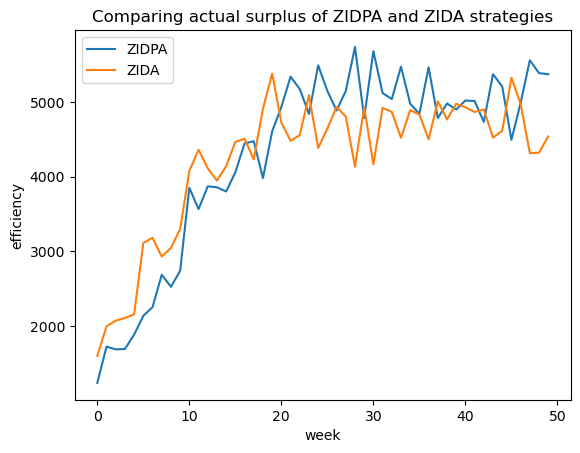

In [46]:
fig, ax = plt.subplots()  
ax.plot(ZIDPA_surplus, label = 'ZIDPA')
ax.plot(ZIDA_surplus, label = 'ZIDA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Comparing actual surplus of ZIDPA and ZIDA strategies')
ax.legend()

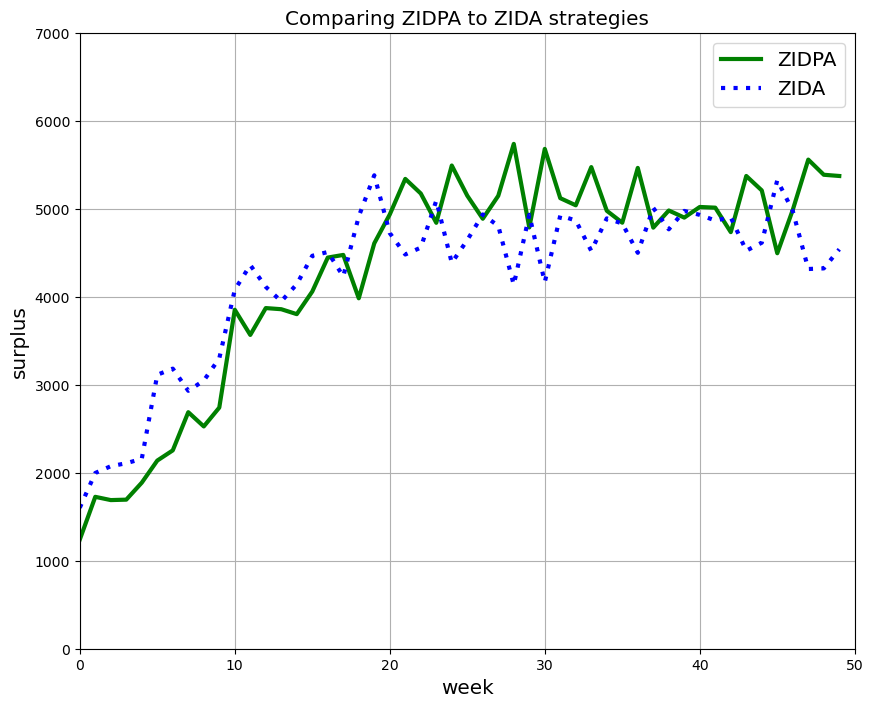

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZIDPA_surplus, label = 'ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(ZIDA_surplus, label = 'ZIDA', linestyle = (0, (1, 2)), color='blue', lw =3)

ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZIDPA to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

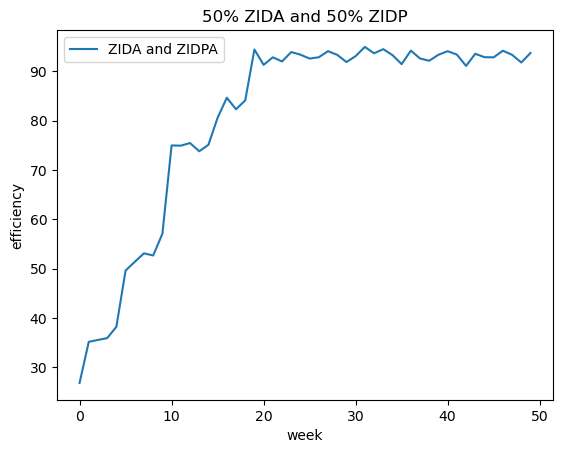

In [48]:
fig, ax = plt.subplots()  
ax.plot(data_table_16, label = 'ZIDA and ZIDPA')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('50% ZIDA and 50% ZIDP')
ax.legend()

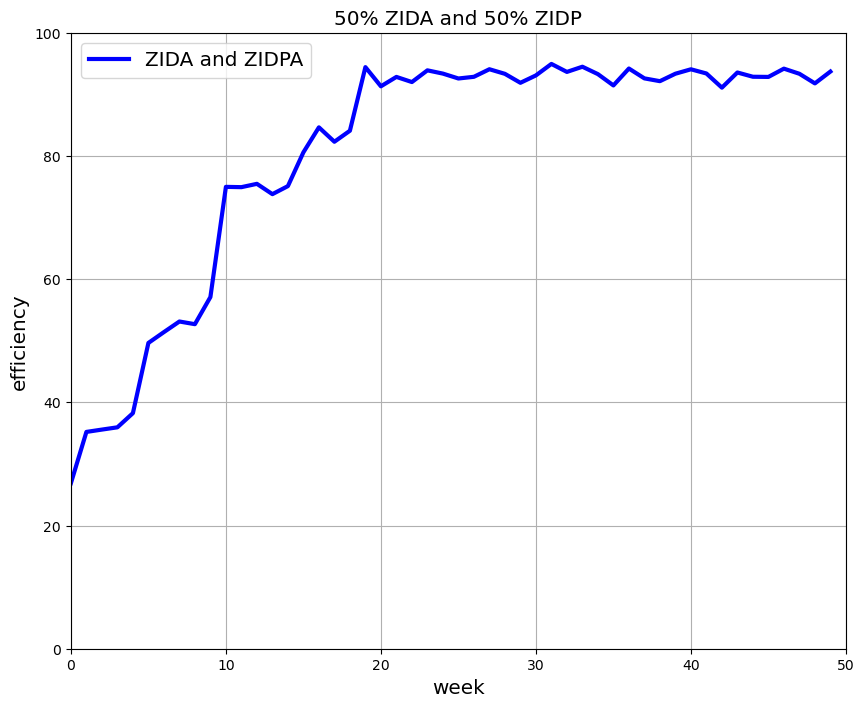

In [49]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_16, label = 'ZIDA and ZIDPA', linestyle = 'solid', color='blue', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('50% ZIDA and 50% ZIDP', size = 'x-large')
ax.legend(fontsize='x-large')

## Compare ZIDPA to ZIDPR

In [51]:
ZID = dm_agents.ZID       # name of agent class
ZIDA = dm_agents.ZIDA     # name of agent class
ZIDP = dm_agents.ZIDP     # name of class that accepts best offer
ZIDPA = dm_agents.ZIDPA 
ZIDPR = dm_agents.ZIDPR 
trader_objects = [(ZIDPA, 10), (ZIDPR,10)]     # List of artificial traders, length 2, can be same
sim_name = "test_one"    # will be the folder name
plot_on = False                   # Plots each week
debug = False                     # Provide verbose information   

num_periods = 7
num_weeks = 100
num_rounds = 5
grid_size = 15
num_traders = 20
num_units = 8
lower_bound = 200 
upper_bound = 600

key = ''
graph_title = "Comparison of surplus realized for ZID vs ZIDP traders"
data_table_19, data_table_20, locs = make_simulation(num_periods,
                   num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                   trader_objects)

ZIDPA_surplus = []
ZIDPR_surplus = []
for type_surplus in data_table_20:
    if 'ZIDPA' in type_surplus:
        ZIDPA_surplus.append(type_surplus['ZIDPA'])
    else:
        ZIDPA_surplus.append(0)
    if 'ZIDPR' in type_surplus:
        ZIDPR_surplus.append(type_surplus['ZIDPR'])
    else:
        ZIDPR_surplus.append(0)   


data_table_21 = [ZIDPA_surplus, ZIDPR_surplus]



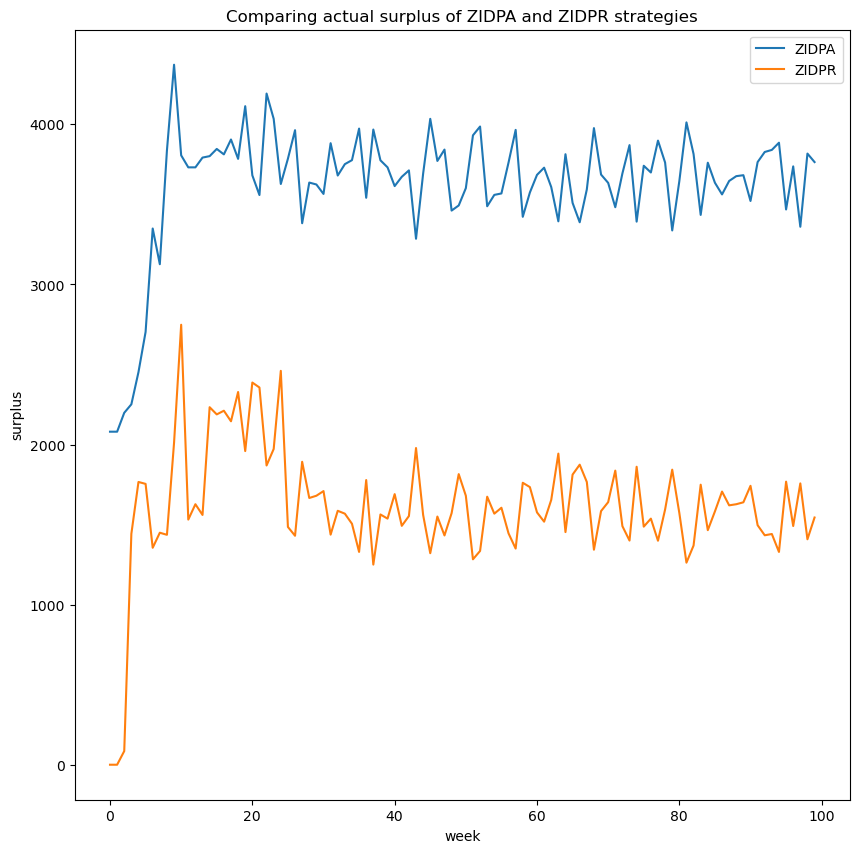

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))  
ax.plot(ZIDPA_surplus, label = 'ZIDPA')
ax.plot(ZIDPR_surplus, label = 'ZIDPR')
ax.set_xlabel('week') 
ax.set_ylabel('surplus') 
ax.set_title('Comparing actual surplus of ZIDPA and ZIDPR strategies')
ax.legend()

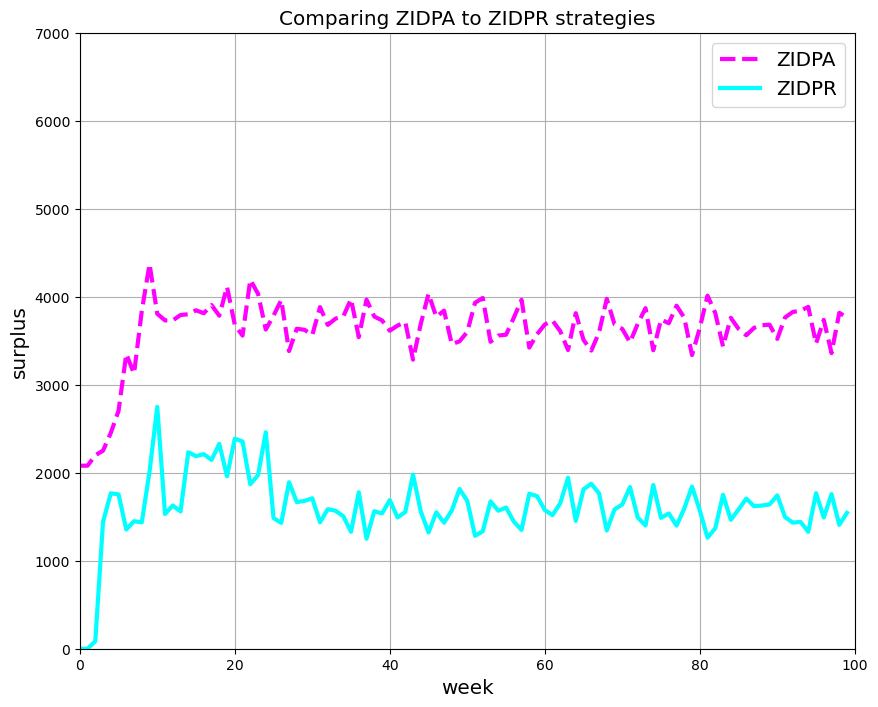

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ZIDPA_surplus, label = 'ZIDPA', linestyle = 'dashed', color='magenta', lw =3)
ax.plot(ZIDPR_surplus, label = 'ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 7000)
ax.grid(1)
ax.set_ylabel('surplus', size = 'x-large') 
ax.set_title('Comparing ZIDPA to ZIDPR strategies', size = 'x-large')
ax.legend(fontsize='x-large')

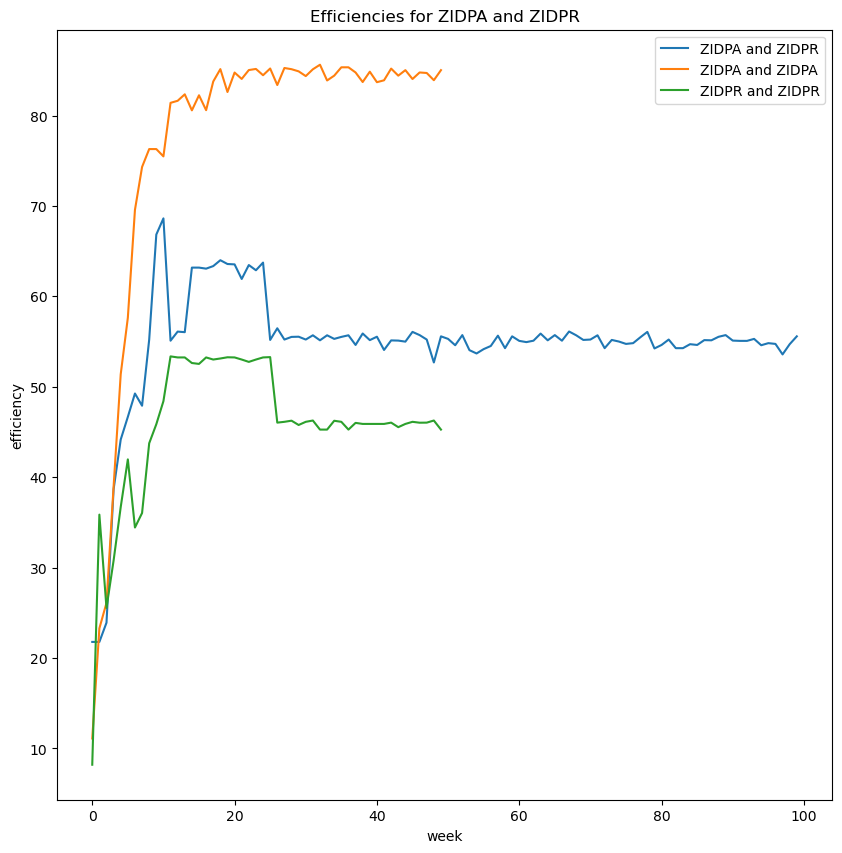

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))  
ax.plot(data_table_19, label = 'ZIDPA and ZIDPR')
ax.plot(data_table_8, label = 'ZIDPA and ZIDPA')
ax.plot(data_table_9, label = 'ZIDPR and ZIDPR')
ax.set_xlabel('week') 
ax.set_ylabel('efficiency') 
ax.set_title('Efficiencies for ZIDPA and ZIDPR')
ax.legend()

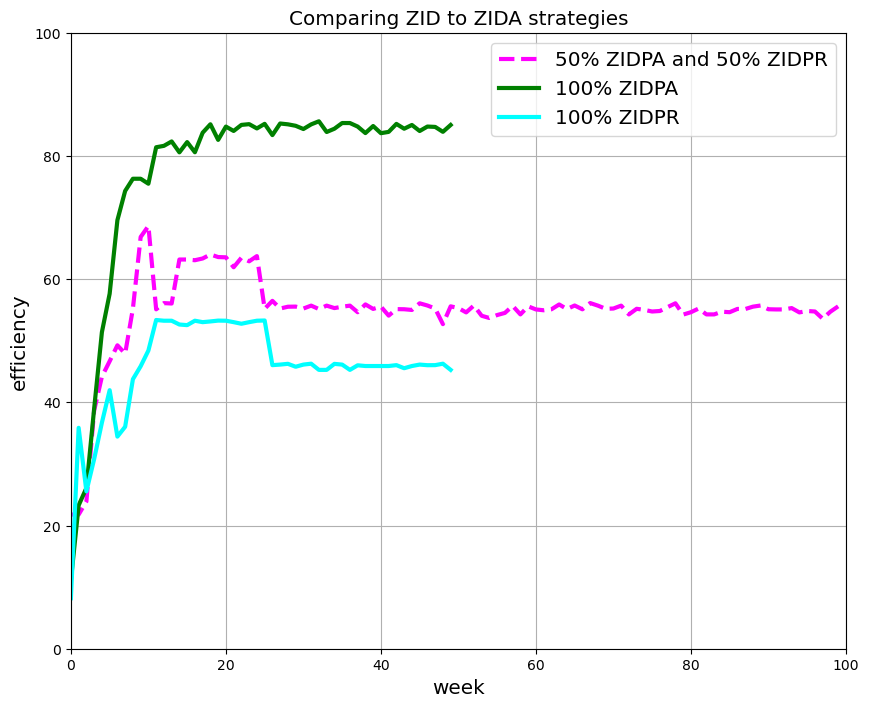

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(data_table_19, label = '50% ZIDPA and 50% ZIDPR', linestyle = 'dashed', color='magenta', lw =3)
ax.plot(data_table_8, label = '100% ZIDPA', linestyle = 'solid', color='green', lw =3)
ax.plot(data_table_9, label = '100% ZIDPR', linestyle = 'solid', color='cyan', lw =3)
ax.set_xlabel('week', size = 'x-large') 
ax.set_xbound(0, num_weeks)
ax.set_ybound(0, 100)
ax.grid(1)
ax.set_ylabel('efficiency', size = 'x-large') 
ax.set_title('Comparing ZID to ZIDA strategies', size = 'x-large')
ax.legend(fontsize='x-large')

In [56]:
def make_locs(agents):
    x = []
    for agent in agents:
        y = agent.get_location()
        x.append(y)
    return x


def make_monte_carlo(num_trials, num_periods, num_weeks,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
    """ 

    effs = []
    type_effs = []
    locs = []
  
    for trial in range(num_trials):
        make_simulation(num_periods, num_weeks,
                   num_rounds, grid_size,
                   num_traders, num_units,
                   lower_bound, upper_bound,
                    trader_objects)

    return effs, type_effs, locs

